# N.B.
- [ ] Create a class to save data into a file
- [ ] Check pauses into the codes and remove redundant ones (or add them if necessary).
- [ ] With sGen.pul_trig_mode(**'AUTO'**) there aren't errors, instead with sGen.pul_trig_mode(**'SING'**) (theorically more correct) the code stops working.  
    *-1074118634: The trigger has not occurred for the requested buffer, so data cannot be fetched relative to the trigger.*
- [ ] controllare se ad alte frequenze se le oscillazioni si vedono anche sull'oscilloscopio



In [1]:
# Uscita trigger dal signal generator: Pulse Sync

%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')

import RS_SMA100B
from Card_Class import *


ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

Connection successful!


# Setup parameters

In [64]:
# parameters for the Signal Generator
f_min           = 10e6                                  # tryout value
f_max           = 50e6                                  # tryout value
pulse_freq      = np.arange(f_min, f_max, 1e6)          # Set range of frequency of the signal to send to the resonator
amplitude       = -25                                   # Set the amplitude of the signal in dBm

pulse_width     = 2                                     # 2 microsec
pulse_delay     = 0
pulse_period    = 400  


sGen.reset()
sGen.clear()
sGen.RF_lvl_ampl(amplitude)
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('AUTO')


# parameters for the Acquisition Card
pxie.voltage_range      = 2.0
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = 250e6

pxie.open()


# Turn ON the modulation of the Signal Generator
sGen.pul_state(1)
sGen.RF_state(1)

# Acquisition of signals for each frequency in the range

In [10]:

slip = 0.0      # time of sleep of triggering

fetched_data = []

for i in pulse_freq:
    #pxie.sample_rate = 2 * i # f_sample > 2*f_max (Nyquist for every freq) 
    
    sGen.RF_freq(i) # guarda come è definito, abbiamo messo la potenza e6   
    sGen.pul_state(1)
    sGen.RF_state(1)
    time.sleep(0.01)
    # wfm = pxie.acquisition(sGen.pul_exe_sing_trig,slip)
    wfm = pxie.acquisition(sGen.pul_exe_sing_trig)
    sGen.pul_state(0)
    sGen.RF_state(0)
    fetched_data += [{'freq': i, 'data': wfm[0].samples.tolist()}]

print('Number of sweeps:', len(fetched_data), '/', len(pulse_freq))


Number of sweeps: 40 / 40


# Plot of a sweep with the peaks of amplitudes marked

In [62]:
def data_plot(y: np.array):
    x = np.arange(len(y))/pxie.sample_rate
    std = np.std(y)
    indices = find_peaks(y, prominence=max(y)*2 - std)
    # plt.clf()
    plt.grid()
    plt.plot(x, y)
    idx = indices[0]
    plt.scatter(x[idx],y[idx], color = 'orange')
    # plt.show()
    return {'mean': np.mean(y[idx]), 'std' : np.std(y[idx])}

In [68]:
f_chosen = fetched_data[4]
print('freq:', f_chosen['freq'])
y = np.array(f_chosen['data'])

data_plot(y)

std = np.std(y)
indices = find_peaks(y, prominence=max(y)*2 - 2*std)

print(np.mean(y[indices[0]]))

freq: 14000000.0
0.01941654760594247


# Save data on HDF5 file

In [6]:
# with h5py.File('nonloso.hdf5', 'a') as f:                      # creo file hdf5 di nome tra virgolette e lo apro in modalità a = appen
#     for j in range(0, len(fetched_data)):
#         gp_data = f.create_group(str(j))
#         freq, data = fetched_data[j].items()
#         gp_data.create_dataset(str(freq[0]), data = freq[1])
#         gp_data.create_dataset(str(data[0]), data = data[1])

# Read data from HDF5 file

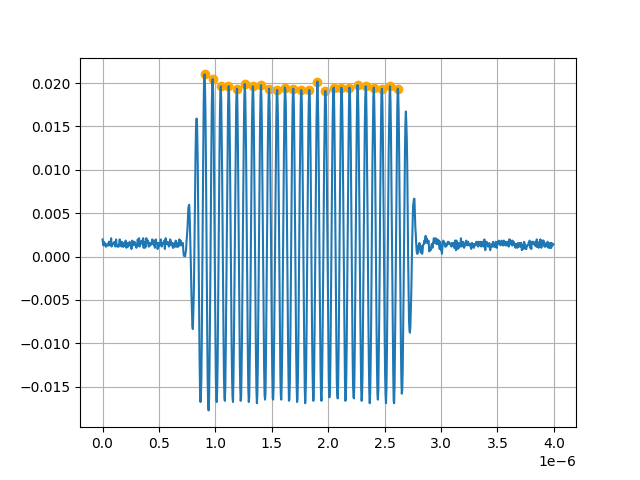

In [69]:
with h5py.File('nonloso.hdf5', 'r') as f:
    idx = 4
    gp = f[str(idx)]
    dic = {}
    for i, k in gp.items():
        dic[i] = k[()]
freq = dic['freq']
data = dic['data']
plt.clf()
data_plot(data)

plt.show()


# First Data Analysis tryout

In [8]:
offset = 2.5e-6
end = 5e-6

with h5py.File('nonloso.hdf5', 'r'):
    

SyntaxError: unexpected EOF while parsing (881495004.py, line 5)

0
{'mean': nan, 'std': nan}
1
{'mean': 0.01937665365403518, 'std': 0.00046376696934819357}
2
{'mean': 0.019498580623933646, 'std': 0.0003555958649533709}
3
{'mean': 0.019646240056317765, 'std': 0.00044241890412526823}
4
{'mean': 0.01960122033604421, 'std': 0.0004137770356069586}
5
{'mean': 0.019505872447755083, 'std': 0.000374530105304083}
6
{'mean': 0.01960901403849832, 'std': 0.00041635852025640585}
7
{'mean': 0.01971974164043786, 'std': 0.0003452729090553704}
8
{'mean': 0.01958881694372394, 'std': 0.0004303286678522844}
9
{'mean': 0.01935945262542061, 'std': 0.0004184969225760967}
10
{'mean': 0.019224723370358777, 'std': 0.00031358703701145867}
11
{'mean': 0.019438307943346445, 'std': 0.0003784498814523458}
12
{'mean': 0.01941310221918684, 'std': 0.000323187562250981}
13
{'mean': 0.019331233267231646, 'std': 0.0003405150953311473}
14
{'mean': 0.01935084488176535, 'std': 0.0004393320690125087}
15
{'mean': 0.01927873213571729, 'std': 0.0003666017652702884}
16
{'mean': 0.01915814359927

c:\Users\oper\SynologyDrive\Lab2023\Qubit\qubit2324\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\oper\SynologyDrive\Lab2023\Qubit\qubit2324\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\oper\SynologyDrive\Lab2023\Qubit\qubit2324\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\oper\SynologyDrive\Lab2023\Qubit\qubit2324\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\oper\SynologyDrive\Lab2023\Qubit\qubit2324\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'mean': 0.018162762962186583, 'std': 0.0009596191667604141}
38
{'mean': 0.01815323912887834, 'std': 0.001019107824656564}
39
{'mean': 0.01801340438436415, 'std': 0.0010321012931921898}


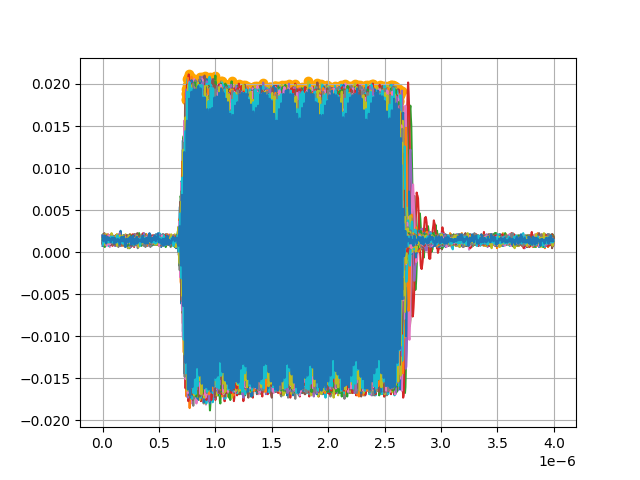

In [63]:
with h5py.File('nonloso.hdf5', 'r') as f:
    for j in range(len(f)):
        print(j)
    # idx = 7
        gp = f[str(j)]
        dic = {}
        for i, k in gp.items():
            dic[i] = k[()]
        freq = dic['freq']
        data = dic['data']

        print(data_plot(data))
plt.show()